<span style="display:block;text-align:center;margin-right:105px"><img src="../media/logos/hacks-logo.png" width="200"/></span>

## Table of Contents

<ul>
    <li><a href='#Dependencies'>Dependencies</a></li>
    </li>
    <li><a href='#Modelling'>Modelling</a>
        <ol style='margin-top: 0em;'>
            <li><a href='#1.-State-Variables'>State Variables</a></li>
            <li><a href='#2.-System-Parameters'>System Parameters</a></li>
            <li><a href='#3.-Policy-Functions'>Policy Functions</a></li>
            <li><a href='#4.-State-Update-Functions'>State Update Functions</a></li>
            <li><a href='#5.-Partial-State-Update-Blocks'>Partial State Update Blocks</a></li>
        </ol>
    </li>
    <li><a href='#Simulation'>Simulation</a>
        <ol style='margin-top: 0em;' start="6">
            <li><a href='#6.-Configuration'>Configuration</a></li>
            <li><a href='#7.-Execution'>Execution</a></li>
            <li><a href='#8.-Output-Preparation'>Output Preparation</a></li>
            <li><a href='#9.-Analysis'>Analysis</a></li>
        </ol>
    </li>
</ul>

---

# Dependencies

In [1]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

In [2]:
# Additional dependencies

# For analytics
import numpy as np
# For visualization
import plotly.express as px

# Hack Specific
import sys
import psutil
import os

# Modelling

## 1. State Variables

In [3]:
initial_state = {
    # List that is going to bust the memory
    'things': np.array([0.0, 1.0]),
    
    # RAM used by the state variables
    'state_bytes': None,
    
    # RAM used by the state history
    'history_bytes': None,
    
    # RAM used by the process
    'process_bytes': None,
    
    # Hack variable that is always nothing
    'nothing': None
}

print(initial_state)

{'things': array([0., 1.]), 'state_bytes': None, 'history_bytes': None, 'process_bytes': None, 'nothing': None}


## 2. System Parameters

In [4]:
system_params = {
    # Number of random numbers to append to a list each timestep
    "amount_of_random_values": [int(1e4)], 
    "erase_history": [True, False]
}

## 4. State Update Functions

In [5]:
def s_add_things(params, substep, history, previous_state, policy_input):
    """
    Add random numbers to the 'things' state variable
    """
    things = previous_state['things']
    N = params['amount_of_random_values']
    values = np.random.rand(N)
    things = np.append(things, values)
    return ('things', things)


def s_measure_history(params, substep, history, previous_state, policy_input):
    """
    Measure how much memory the 'things' state variable history is using
    """
    historic_bytes = [sys.getsizeof(substep_state.get('things', 0)) 
                      for timestep_state in history 
                      for substep_state in timestep_state]
    used_bytes = sum(historic_bytes)
    return ('history_bytes', used_bytes)


def s_measure_state(params, substep, history, previous_state, policy_input):
    """
    Measure how much memory the 'things' state variable is using
    """
    used_bytes = sys.getsizeof(previous_state['things'])
    return ('state_bytes', used_bytes)


def s_measure_process(params, substep, history, previous_state, policy_input):
    """
    Get the current process and see how much memory is on it
    """
    process = psutil.Process(os.getpid())
    used_bytes = process.memory_info().data
    return ('process_bytes', used_bytes)


def s_erase_history(params, substep, history, previous_state, policy_input):
    """
    Iterate on the history and erase everything
    """
    if params['erase_history'] is True:
        for timestep_state in history:
            for substep_state in timestep_state:
                substep_state['things'] = None
    return ('nothing', None)

## 5. Partial State Update Blocks

In [6]:
partial_state_update_blocks = [
  {
      # Add lots of random numbers to the simulation
      'policies': {},
      'variables': {
          'things': s_add_things
      }
  },
  {
      # Measure memory usage
      'policies': {},
      'variables': {
          'state_bytes': s_measure_state,
          'history_bytes': s_measure_history,
          'process_bytes':s_measure_process
      }
  },
  {
      # Erase history of the variables
      'policies': {},
      'variables': {
          'nothing': s_erase_history
      }
  },
]

# Simulation

## 6. Configuration

In [7]:
sim_config = config_sim({
    "N": 1, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(200), # the number of timesteps the simulation will run for
    "M": system_params # the parameters of the system
})

In [8]:
del configs[:] # Clear any prior configs

In [9]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## 7. Execution

In [10]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (200, 2, 2, 5)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 1]
Ns       : [0, 1]
ExpIDs   : [0, 0]
Execution Mode: parallelized
Total execution time: 13.60s


## 8. Output Preparation

In [11]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(10)

,things,state_bytes,history_bytes,process_bytes,nothing,simulation,subset,run,substep,timestep,amount_of_random_values,erase_history
0,None,NaN,NaN,NaN,None,0,0,1,0,0,10000,True
1,None,NaN,NaN,NaN,None,0,0,1,1,1,10000,True
2,None,80112.0,112.0,727597056.0,None,0,0,1,2,1,10000,True
3,None,80112.0,112.0,727597056.0,None,0,0,1,3,1,10000,True
4,None,80112.0,112.0,727597056.0,None,0,0,1,1,2,10000,True
5,None,160112.0,240352.0,727994368.0,None,0,0,1,2,2,10000,True
6,None,160112.0,240352.0,727994368.0,None,0,0,1,3,2,10000,True
7,None,160112.0,240352.0,727994368.0,None,0,0,1,1,3,10000,True
8,None,240112.0,480400.0,728715264.0,None,0,0,1,2,3,10000,True
9,None,240112.0,480400.0,728715264.0,None,0,0,1,3,3,10000,True


## 9. Analysis

In [12]:
pd.options.plotting.backend = "plotly"

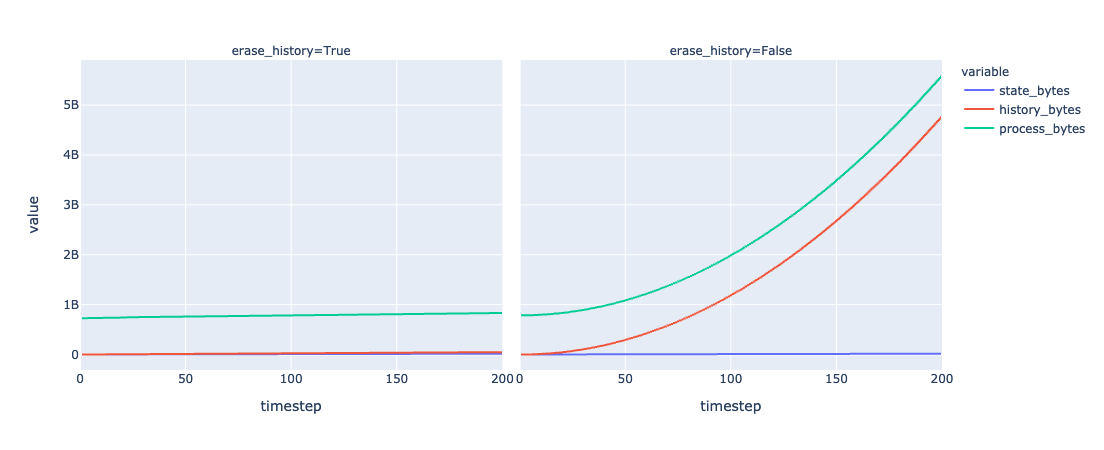

In [13]:
# Plot the used memory in bytes
px.line(df,
        x='timestep',
        y=['state_bytes', 'history_bytes', 'process_bytes'],
        facet_col='erase_history'
       )

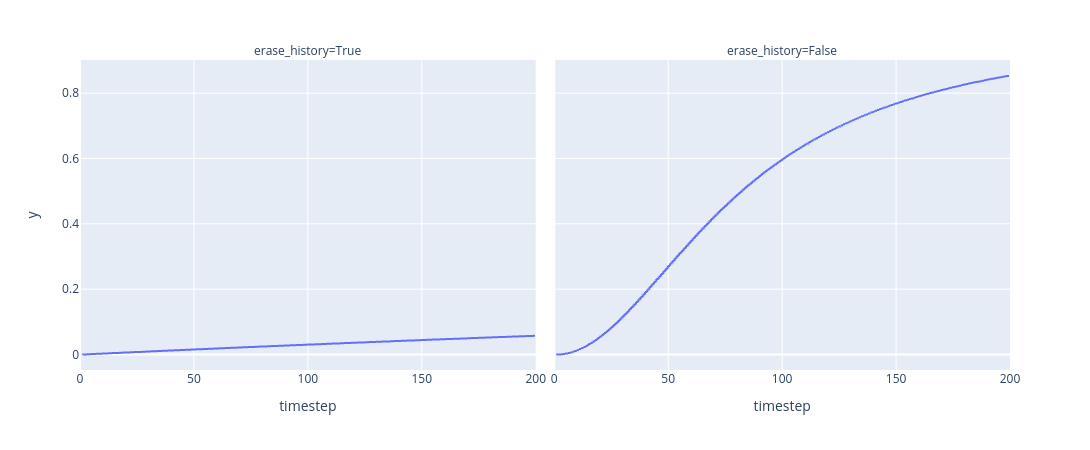

In [14]:
# Share of the process bytes being used for keeping memory
px.line(df,
        x='timestep',
        y=df.history_bytes / df.process_bytes,
        facet_col='erase_history'
       )